In [11]:
import numpy as np
from netCDF4 import Dataset
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [8]:
f1 = Dataset('../multi_eof.nc', 'r')
f2 = Dataset('../gpcc.r.1x1.classified.nc', 'r')
r = f2.variables['r']
x0 = f1.variables['eof_ts']
x = np.transpose(x0)

In [19]:
lat = f2.variables['lat'][:]
lon = f2.variables['lon'][:]
lat_bnds, lon_bnds = [-18, -2], [287, 313]
lat_inds = np.where((lat > lat_bnds[0]) & (lat < lat_bnds[1]))[0]
lon_inds = np.where((lon > lon_bnds[0]) & (lon < lon_bnds[1]))[0]
#y = rain.variables['r'][:,:,np.min(lat_inds):np.max(lat_inds),np.min(lon_inds):np.max(lon_inds)]
y = f2.variables['r'][:,:,lat_inds,lon_inds]

In [20]:
nyear = len(f2.variables['year'])
nmonth = len(f2.variables['month'])
nlat = len(lat_inds)
nlon = len(lon_inds) 

# This is normal logistic regression

In [34]:
predictY = np.zeros((nyear,nmonth,nlat,nlon))
accuracy_val = np.zeros((nmonth,nlat,nlon))
accuracy_test = np.zeros((nmonth,nlat,nlon))

for ilat in range(nlat):
    for ilon in range(nlon):
        for imonth in range(nmonth):
            reg = LogisticRegression()
            reg.fit(x[0:30,:],y[0:30,imonth,ilat,ilon])
            predictY[:,imonth,ilat,ilon] = reg.predict(x)
            #print(reg.predict_proba(x).shape)
            del reg
            accuracy_val[imonth,ilat,ilon] = metrics.accuracy_score(y[0:30,imonth,ilat,ilon], predictY[0:30,imonth,ilat,ilon])
            accuracy_test[imonth,ilat,ilon] = metrics.accuracy_score(y[30:nyear,imonth,ilat,ilon], predictY[30:nyear,imonth,ilat,ilon])

In [30]:
pr = Dataset('predict.r.logistic.simple.nc', 'w',format='NETCDF3_64BIT')
pr.description = 'predicted rainfall anomalies using simple logistic regression'

pr.createDimension('year', nyear)
pr.createDimension('month', nmonth)
pr.createDimension('lat', nlat)
pr.createDimension('lon', nlon)

fyear = pr.createVariable('year', 'f', ('year',))
fmonth = pr.createVariable('month', 'f', ('month',))
flat = pr.createVariable('lat', 'f', ('lat',))
flon = pr.createVariable('lon', 'f', ('lon',))
newr = pr.createVariable('r', 'f4', ('year', 'month','lat','lon'),fill_value=-999)
acc_val = pr.createVariable('acc_val', 'f4', ('month','lat','lon'),fill_value=-999)
acc_test = pr.createVariable('acc_test', 'f4', ('month','lat','lon'),fill_value=-999)

fyear[:] = f2.variables['year']
fmonth[:] = f2.variables['month']
flat[:] = f2.variables['lat'][lat_inds]
flon[:] = f2.variables['lon'][lon_inds]
newr[:,:,:,:] = predictY[:,:,:,:]
acc_val[:,:,:] = accuracy_val[:,:,:]
acc_test[:,:,:] = accuracy_test[:,:,:]
flat.units = "degrees_north"
flat.long_name = "Latitude"
flon.units = "degrees_east"
flon.long_name = "Longitude"
newr.long_name = 'predicted rainfall anomalies using simple logistic regression'
pr.close()

# This is for Logistic regression to find out the best alpha

In [64]:
def sigmoid(z):
    return np.divide(1.0,(1.0 + np.exp(-z)))
    
def compute_cost(Y, predictY):
    y = np.zeros(len(predictY))
    y[Y-np.min(Y)] = 1
    Jc = np.sum(np.dot(-y,np.log(sigmoid(predictY)))-np.dot((1-y),np.log(1.-sigmoid(predictY))))
    return Jc

In [65]:
n_lambdas = 200
lambdas = np.logspace(-4, 8, n_lambdas)

vRSS = []
tRSS = []
for imonth in range(nmonth):
    for ia in range(len(lambdas)):
        validation_RSS = 0.
        test_RSS = 0.
        reg = LogisticRegression (C = lambdas[ia])
        
        for ilat in range(nlat):
            for ilon in range(nlon):
                reg.fit(x[0:30,:],y[0:30,imonth,ilat,ilon])
                predictY = reg.predict_proba(x)
                
                for iyear in range(30):
                    validation_RSS = validation_RSS + compute_cost(y[iyear,imonth,ilat,ilon],predictY[iyear,:])
                    
                for iyear in range(nyear-30):
                    test_RSS = test_RSS + compute_cost(y[iyear+30,imonth,ilat,ilon],predictY[iyear+30,:])
                    
                del predictY
        vRSS.append(validation_RSS)
        tRSS.append(test_RSS)
        del reg,validation_RSS,test_RSS
print("completed!")

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/base.py:284: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


completed!


0.0001


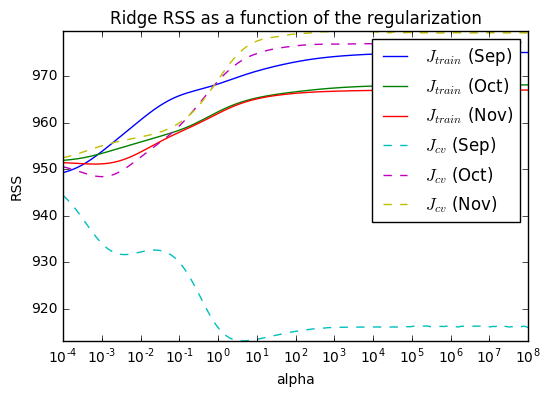

In [67]:
ax = plt.gca()

ax.plot(lambdas, np.array(vRSS[0:200])/30.,label='$J_{train}$ (Sep)')
ax.plot(lambdas, np.array(vRSS[200:400])/30.,label='$J_{train}$ (Oct)')
ax.plot(lambdas, np.array(vRSS[400:600])/30.,label='$J_{train}$ (Nov)')
ax.plot(lambdas, np.array(tRSS[0:200])/(nyear-30.),'--',label='$J_{cv}$ (Sep)')
ax.plot(lambdas, np.array(tRSS[200:400])/(nyear-30.),'--',label='$J_{cv}$ (Oct)')
ax.plot(lambdas, np.array(tRSS[400:600])/(nyear-30.),'--',label='$J_{cv}$ (Nov)')
total = (np.array(vRSS[0:200])+np.array(vRSS[200:400])+np.array(vRSS[400:600])+np.array(tRSS[0:200])+np.array(tRSS[200:400])+np.array(tRSS[400:600]))/6./nyear
#ax.plot(alphas, total,'--',label='average',linewidth=2.0)
print(lambdas[np.argmin(total)])

plt.xlabel('alpha')
plt.ylabel('RSS')
plt.title('Ridge RSS as a function of the regularization')
plt.axis('tight')
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
#ax.set_ylim([0.,1500.])
plt.legend()

plt.show()   
#plt.savefig('Ridge.jpg', format='jpg', dpi=1000)

# with regulization

In [84]:
predictY = np.zeros((nyear,nmonth,nlat,nlon))
accuracy_val = np.zeros((nmonth,nlat,nlon))
accuracy_test = np.zeros((nmonth,nlat,nlon))

for ilat in range(nlat):
    for ilon in range(nlon):
        for imonth in range(nmonth):
            reg = LogisticRegression(C=1e5)
            reg.fit(x[0:32,:],y[0:32,imonth,ilat,ilon])
            predictY[:,imonth,ilat,ilon] = reg.predict(x)
            #print(reg.predict_proba(x).shape)
            del reg
            accuracy_val[imonth,ilat,ilon] = metrics.accuracy_score(y[0:30,imonth,ilat,ilon], predictY[0:30,imonth,ilat,ilon])
            accuracy_test[imonth,ilat,ilon] = metrics.accuracy_score(y[30:nyear,imonth,ilat,ilon], predictY[30:nyear,imonth,ilat,ilon])

In [85]:
pr = Dataset('predict.r.logistic.regulization.nc', 'w',format='NETCDF3_64BIT')
pr.description = 'predicted rainfall anomalies using simple logistic regression'

pr.createDimension('year', nyear)
pr.createDimension('month', nmonth)
pr.createDimension('lat', nlat)
pr.createDimension('lon', nlon)

fyear = pr.createVariable('year', 'f', ('year',))
fmonth = pr.createVariable('month', 'f', ('month',))
flat = pr.createVariable('lat', 'f', ('lat',))
flon = pr.createVariable('lon', 'f', ('lon',))
newr = pr.createVariable('r', 'f4', ('year', 'month','lat','lon'),fill_value=-999)
acc_val = pr.createVariable('acc_val', 'f4', ('month','lat','lon'),fill_value=-999)
acc_test = pr.createVariable('acc_test', 'f4', ('month','lat','lon'),fill_value=-999)

fyear[:] = f2.variables['year']
fmonth[:] = f2.variables['month']
flat[:] = f2.variables['lat'][lat_inds]
flon[:] = f2.variables['lon'][lon_inds]
newr[:,:,:,:] = predictY[:,:,:,:]
acc_val[:,:,:] = accuracy_val[:,:,:]
acc_test[:,:,:] = accuracy_test[:,:,:]
flat.units = "degrees_north"
flat.long_name = "Latitude"
flon.units = "degrees_east"
flon.long_name = "Longitude"
newr.long_name = 'predicted rainfall anomalies using simple logistic regression'
pr.close()